## Simulate pseudotime

The first part of this code involves simulating cell states at sampling times. 

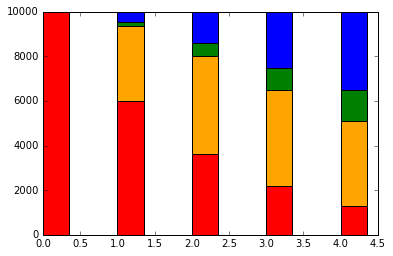

In [304]:
import numpy as np
import matplotlib.pyplot as plt

lambda1 = 0.5
lambda2 = 0.1
lambda3 = 0.25

num_cells = 10000
num_cell_types = 4
type1_times = np.random.exponential(1/lambda1,num_cells)
type2_times = np.random.exponential(1/lambda2,num_cells)
type3_times = np.random.exponential(1/lambda3,num_cells)

# Determine end states
all_trans_vects = []
for i in range(num_cells):
    all_trans_vects.append([])
    all_trans_vects[i].append((1,type1_times[i]))
    if type2_times[i] < type3_times[i]: 
        all_trans_vects[i].append((2,type1_times[i]+type2_times[i]))
    else: 
        all_trans_vects[i].append((3,type1_times[i]+type3_times[i]))
        
# Count each type of cell at each observation time
def determine_cell_type_at_t(t,trans_vects):
    cell_types = [0]+[i[0] for i in trans_vects]
    cell_type_ind = 0
    for trans in trans_vects:
        if  t > trans[1]:
            cell_type_ind += 1
    return cell_types[cell_type_ind]

obs_times = range(1,5)
type_counts = [[num_cells,0,0,0]]
for i,t in enumerate(obs_times):
    type_counts.append(np.bincount(map(determine_cell_type_at_t,
                                       [t for i in range(num_cells)],all_trans_vects)))

# Plot
times = np.array(type_counts).T
bottom=np.zeros(5)
colors=["red","orange","green",'blue']
ind=range(5)
width = 0.35
for i in range(4):
    p1 = plt.bar(ind, times[i], width, color=colors[i],bottom=bottom)
    bottom=bottom+np.array(times[i])

## Estimating rate parameters
If we know the state of each cell at each of 5 sampling points, and we know the underlying chain model, can we estimate the exponential rate parameters underpinning transition rates?

In [305]:
import scipy.optimize
def estimate_rate_parameters_for_Y(times,t):
    # Estimate lambda1
    est_l1 = []
    for i in range(1,len(times[0])):
        est_l1.append(-np.log(float(times[0][i])/times[0][0])/t[i])
    l1 = np.median(est_l1)
    
    # Estimate lambda2 + lambda3
    est_l2,est_l3 = [],[]
    for i in range(1,len(times[0])):
        c = float(times[1][i])/times[0][0]
        def F(x):
            return l1*np.exp(-x*t[i])*(np.exp(t[i]*(-l1+x))-1)/(-l1+x)-c
        b = scipy.optimize.broyden1(F,0.25,f_tol=1e-14)
        a = float(times[2][i])/times[3][i]
        est_l3.append(b/(a+1))
        est_l2.append(a*b/(a+1))
    l2 = np.median(est_l2)
    l3 = np.median(est_l3)
    
    return l1, l2, l3

In [310]:
estimate_rate_parameters_for_Y(times,range(5))

(0.50936876405681331, 0.097521785158570712, 0.24184880821162108)